# What persistent homology actually does

Persistent homology starts from a **filtered simplicial complex**.

Given your point cloud X (e.g., points of the form (strike, maturity, implied vol)):

- For every scale parameter α ≥ 0, construct the Vietoris–Rips complex K_α at scale α.  
  → An edge appears between two points if their distance ≤ α  
  → A triangle appears if every pair of its three points is connected by edges  
  → And so on for higher simplices (tetrahedra, etc.)

This creates a **filtration**:  
K₀ ⊆ K_{α₁} ⊆ K_{α₂} ⊆ … ⊆ K_∞ = the full (complete) complex as α → ∞

For each dimension k (0 = connected components, 1 = loops/holes, 2 = voids/cavities, …):

- Compute the homology groups H_k(K_α) at each scale α  
- The inclusion maps K_α → K_β (for α ≤ β) induce linear maps on homology:  
  f_{k}^{α,β} : H_k(K_α) → H_k(K_β)

The **persistent homology** in dimension k is the full collection of these induced maps across the entire filtration.


# Simple TDA for Volatility Surfaces: A Beginner's Guide

This notebook shows how **Persistent Homology** — one of the core tools of **Topological Data Analysis (TDA)** — can be used to study **implied volatility surfaces** in a new way.

### What is a volatility surface?

A **volatility surface** is a 3D representation of **implied volatility** across different **strike prices** (how far in/out-of-the-money the option is) and different **maturities** (time until expiration).  
Instead of looking at just one option, you see the whole market's expectation of future volatility at once.

Typical real-world patterns include:

- **Volatility smile**: implied vol is higher for deep out-of-the-money (OTM) and deep in-the-money (ITM) options compared to at-the-money (ATM). This looks like a U-shape / smile.
- **Volatility smirk**: the smile is skewed, usually much higher vol on the put side than on the call side this occururence is common after market crashes.


## What we'll cover
1. How to represent a volatility surface as a point cloud
2. How to compute persistent homology using Vietoris-Rips filtration
3. How to interpret persistence diagrams and barcodes
4. What topological features tell us about market structure

### Intuition: Volatility surface as a landscape

Imagine the volatility surface as a hilly landscape:

- Height = implied volatility  
- x-axis = strike price (or moneyness)  
- y-axis = time to maturity

Persistent homology is like slowly flooding this landscape with water and watching what happens:

- **0-dimensional features** (connected regions / "islands")  
  clusters of similar volatility levels  

- **1-dimensional features** (holes / loops)  
  holes in the surface  

- **2-dimensional features** (cavities / enclosed voids)  
  enclosed air pockets trapped under the surface  

### What might these topological features represent in markets?

| Topological feature | Possible market interpretation                        | Example in practice                                      |
|----------------------|-------------------------------------------------------|------------------------------------------------------------------|
| Long-lived H₀        | Strong clusters / regimes                             | Low-vol regime vs. crisis regime                             |
| Long-lived H₁        | Prominent smile or smirk                              | Equity index options after 2008 — strong downside smirk      |
| Short-lived H₁       | Small-scale noise or microstructure effects           | Illiquid strikes/maturity buckets                            |
| Long-lived H₂        | Large-scale cavity or dislocation                     | Mispricings, arbitrage opportunities, or market breaks       |
| Sudden birth/death   | Regime shift or market event                          | Flash crash, central bank announcement, earnings surprise    |

By looking at which topological features **last the longest** (high persistence), we can often separate **structurally important market phenomena** from noise.

In [2]:
# Install required packages
!pip install ripser persim scikit-learn numpy matplotlib scipy

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

# TDA libraries
from ripser import ripser
from persim import plot_diagrams

#plot library
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.1/842.1 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.3 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=3c7d0c402076271733e8ffb92ee93c8f144ae5bd98643a918f395b8159b2a27b
  Stored in directory: /root/.cache/pip/wheels/2a/fd/fe/f4b8fd82894e1d9e04040ef41dc5ae6eb7a8e9b0ef5a9402fe
Successfully built hopcroftkarp


## Step 1: Create a Volatility Surface

We'll use the Black-Scholes to generate implied volatilities.

In [3]:
# Black-Scholes Functions for call/put options
def black_scholes_call(S, K, T, r, sigma):
    """Black-Scholes call option price"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    """Black-Scholes put option price"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Parameters
S0 = 100  # Current stock price
r = 0.05  # Risk-free rate

# Create grid of strikes and maturities
strikes = np.linspace(80, 120, 20)  # Strike prices
maturities = np.linspace(0.1, 2.0, 20)  # Time to maturity in years
K_grid, T_grid = np.meshgrid(strikes, maturities)

# Generate volatility surface with a smile pattern
moneyness = K_grid / S0
base_vol = 0.20

# Add volatility smile (higher vol for OTM options)
vol_surface = base_vol + 0.15 * (moneyness - 1)**2 + 0.05 * np.sin(T_grid * 3)

# Add some realistic noise
np.random.seed(42)
vol_surface += np.random.normal(0, 0.02, vol_surface.shape)

print(f"Volatility surface shape: {vol_surface.shape}")
print(f"Min volatility: {vol_surface.min():.2%}")
print(f"Max volatility: {vol_surface.max():.2%}")

Volatility surface shape: (20, 20)
Min volatility: 9.53%
Max volatility: 29.88%


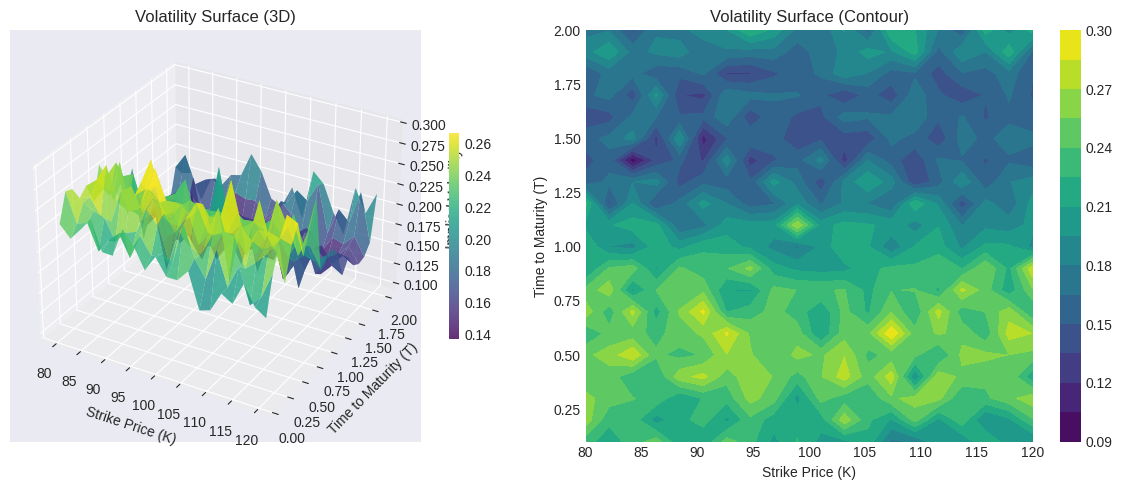

In [4]:
# Visualize the volatility surface
fig = plt.figure(figsize=(12, 5))

# 3D surface plot
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(K_grid, T_grid, vol_surface, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Strike Price (K)')
ax1.set_ylabel('Time to Maturity (T)')
ax1.set_zlabel('Implied Volatility')
ax1.set_title('Volatility Surface (3D)')
plt.colorbar(surf, ax=ax1, shrink=0.5)

# Contour plot
ax2 = fig.add_subplot(122)
contour = ax2.contourf(K_grid, T_grid, vol_surface, levels=15, cmap='viridis')
ax2.set_xlabel('Strike Price (K)')
ax2.set_ylabel('Time to Maturity (T)')
ax2.set_title('Volatility Surface (Contour)')
plt.colorbar(contour, ax=ax2)

plt.tight_layout()
plt.show()

## Step 2: Prepare Data for TDA

We need to convert our volatility surface into a **point cloud** - a collection of points in 3D space where:
- x-axis: Strike price (or moneyness)
- y-axis: Time to maturity
- z-axis: Implied volatility

**Important**: We'll normalize the data so all dimensions have similar scales. This prevents one dimension from dominating the distance calculations.

In [5]:
# Flatten the grids to create point cloud
strikes_flat = K_grid.flatten()
maturities_flat = T_grid.flatten()
vols_flat = vol_surface.flatten()

# Create point cloud (N x 3 array)
point_cloud = np.column_stack([strikes_flat, maturities_flat, vols_flat])

print(f"Point cloud shape: {point_cloud.shape}")
print(f"Number of points: {len(point_cloud)}")
print(f"\nFirst 5 points:")
print(point_cloud[:5])

Point cloud shape: (400, 3)
Number of points: 400

First 5 points:
[[80.          0.1         0.23071029]
 [82.10526316  0.1         0.21681405]
 [84.21052632  0.1         0.23146939]
 [86.31578947  0.1         0.24804547]
 [88.42105263  0.1         0.21210402]]


In [6]:
# Normalize the data (important for TDA!)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
point_cloud_normalized = scaler.fit_transform(point_cloud)

print("Data normalized!")
print(f"\nMean of normalized data: {point_cloud_normalized.mean(axis=0)}")
print(f"Std of normalized data: {point_cloud_normalized.std(axis=0)}")

Data normalized!

Mean of normalized data: [-1.24011912e-15  4.10782519e-17  2.37476705e-15]
Std of normalized data: [1. 1. 1.]


## Step 3: Compute Persistent Homology

### What is Persistent Homology?

Imagine slowly "growing" balls around each point in your data:
1. Start with radius = 0 (just individual points)
2. Gradually increase the radius
3. When balls touch, points become "connected"
4. Track when features (components, holes) appear and disappear

### The Output:
- **H0 (0-dimensional)**: Connected components (clusters)
- **H1 (1-dimensional)**: Loops/holes (like a donut hole)
- **H2 (2-dimensional)**: Voids (like a hollow sphere)

We use the **Ripser** library - it's fast and easy to use!

In [7]:
# Compute persistent homology
# maxdim=2 means we compute H0, H1, and H2
result = ripser(point_cloud_normalized, maxdim=2)

# Extract persistence diagrams
diagrams = result['dgms']

print("Persistent homology computed!")
print(f"\nNumber of H0 features (components): {len(diagrams[0])}")
print(f"Number of H1 features (holes): {len(diagrams[1])}")
print(f"Number of H2 features (voids): {len(diagrams[2])}")

Persistent homology computed!

Number of H0 features (components): 400
Number of H1 features (holes): 181
Number of H2 features (voids): 24


## Step 4: Visualize Persistence Diagrams

### How to Read a Persistence Diagram:

- **X-axis (Birth)**: When a feature appears
- **Y-axis (Death)**: When a feature disappears
- **Distance from diagonal**: How long a feature persists ("lifetime")
- **Points near diagonal**: Short-lived features (probably noise)
- **Points far from diagonal**: Long-lived features (important structure!)

### What to Look For:
- **H0**: One dominant point far from diagonal = one main connected component
- **H1**: Points far from diagonal = significant holes/loops in the data
- **H2**: Points far from diagonal = significant voids

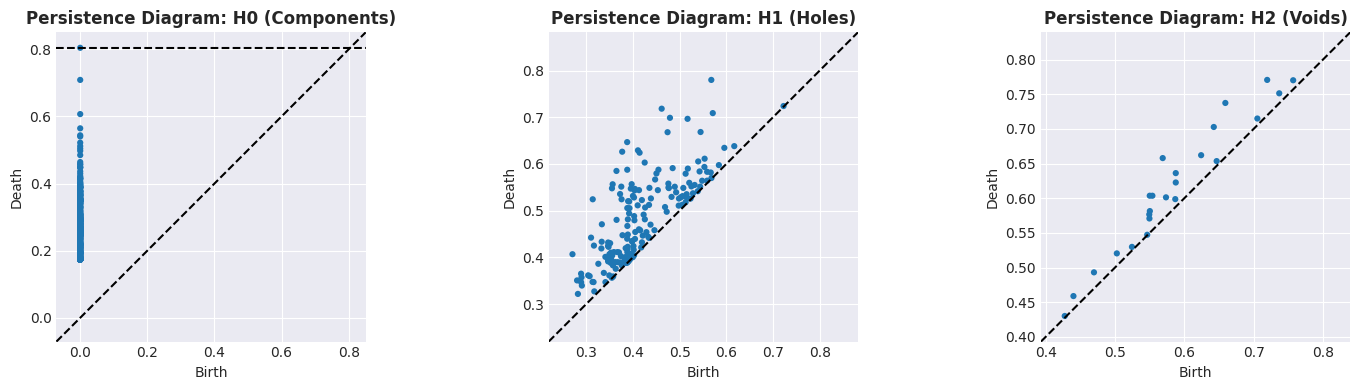


 Interpretation Tips:
- Points far from the diagonal represent significant features
- Points near the diagonal are likely noise
- The further from diagonal, the more 'persistent' the feature


In [8]:
# Plot persistence diagrams
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (ax, dim_name) in enumerate(zip(axes, ['H0 (Components)', 'H1 (Holes)', 'H2 (Voids)'])):
    plot_diagrams(diagrams[i:i+1], ax=ax, legend=False)
    ax.set_title(f'Persistence Diagram: {dim_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')

plt.tight_layout()
plt.show()

print("\n Interpretation Tips:")
print("- Points far from the diagonal represent significant features")
print("- Points near the diagonal are likely noise")
print("- The further from diagonal, the more 'persistent' the feature")

## Step 5: Analyze Feature Persistence

Let's quantify which features are most important by calculating their **persistence** (lifetime).

In [9]:
def analyze_persistence(diagrams):
    """Analyze and rank features by persistence"""

    for dim, name in enumerate(['H0 (Components)', 'H1 (Holes)', 'H2 (Voids)']):
        print(f"\n{'='*60}")
        print(f"{name}")
        print(f"{'='*60}")

        diagram = diagrams[dim]

        # Calculate persistence (death - birth)
        # Handle infinite death times (features that never die)
        persistence = []
        for birth, death in diagram:
            if np.isinf(death):
                pers = float('inf')
            else:
                pers = death - birth
            persistence.append((birth, death, pers))

        # Sort by persistence (descending)
        persistence.sort(key=lambda x: x[2] if not np.isinf(x[2]) else float('inf'), reverse=True)

        # Show top 5 most persistent features
        print(f"\nTop 5 most persistent features:")
        print(f"{'Rank':<6} {'Birth':<12} {'Death':<12} {'Persistence':<12}")
        print("-" * 50)

        for rank, (birth, death, pers) in enumerate(persistence[:5], 1):
            death_str = "∞" if np.isinf(death) else f"{death:.4f}"
            pers_str = "∞" if np.isinf(pers) else f"{pers:.4f}"
            print(f"{rank:<6} {birth:<12.4f} {death_str:<12} {pers_str:<12}")

        # Statistics
        finite_pers = [p for _, _, p in persistence if not np.isinf(p)]
        if finite_pers:
            print(f"\nStatistics (finite features):")
            print(f"  Total features: {len(diagram)}")
            print(f"  Mean persistence: {np.mean(finite_pers):.4f}")
            print(f"  Median persistence: {np.median(finite_pers):.4f}")
            print(f"  Max persistence: {np.max(finite_pers):.4f}")

analyze_persistence(diagrams)


H0 (Components)

Top 5 most persistent features:
Rank   Birth        Death        Persistence 
--------------------------------------------------
1      0.0000       ∞            ∞           
2      0.0000       0.7090       0.7090      
3      0.0000       0.6071       0.6071      
4      0.0000       0.5647       0.5647      
5      0.0000       0.5439       0.5439      

Statistics (finite features):
  Total features: 400
  Mean persistence: 0.2777
  Median persistence: 0.2620
  Max persistence: 0.7090

H1 (Holes)

Top 5 most persistent features:
Rank   Birth        Death        Persistence 
--------------------------------------------------
1      0.3878       0.6468       0.2590      
2      0.4617       0.7184       0.2567      
3      0.3771       0.6263       0.2491      
4      0.3649       0.5851       0.2202      
5      0.4794       0.6989       0.2195      

Statistics (finite features):
  Total features: 181
  Mean persistence: 0.0649
  Median persistence: 0.0467
  Max p

## Step 6: Persistence Barcodes

Barcodes are another way to visualize the same information:
- Each horizontal bar represents a topological feature
- **Length of bar** = persistence (lifetime) of the feature
- **Longer bars** = more important features

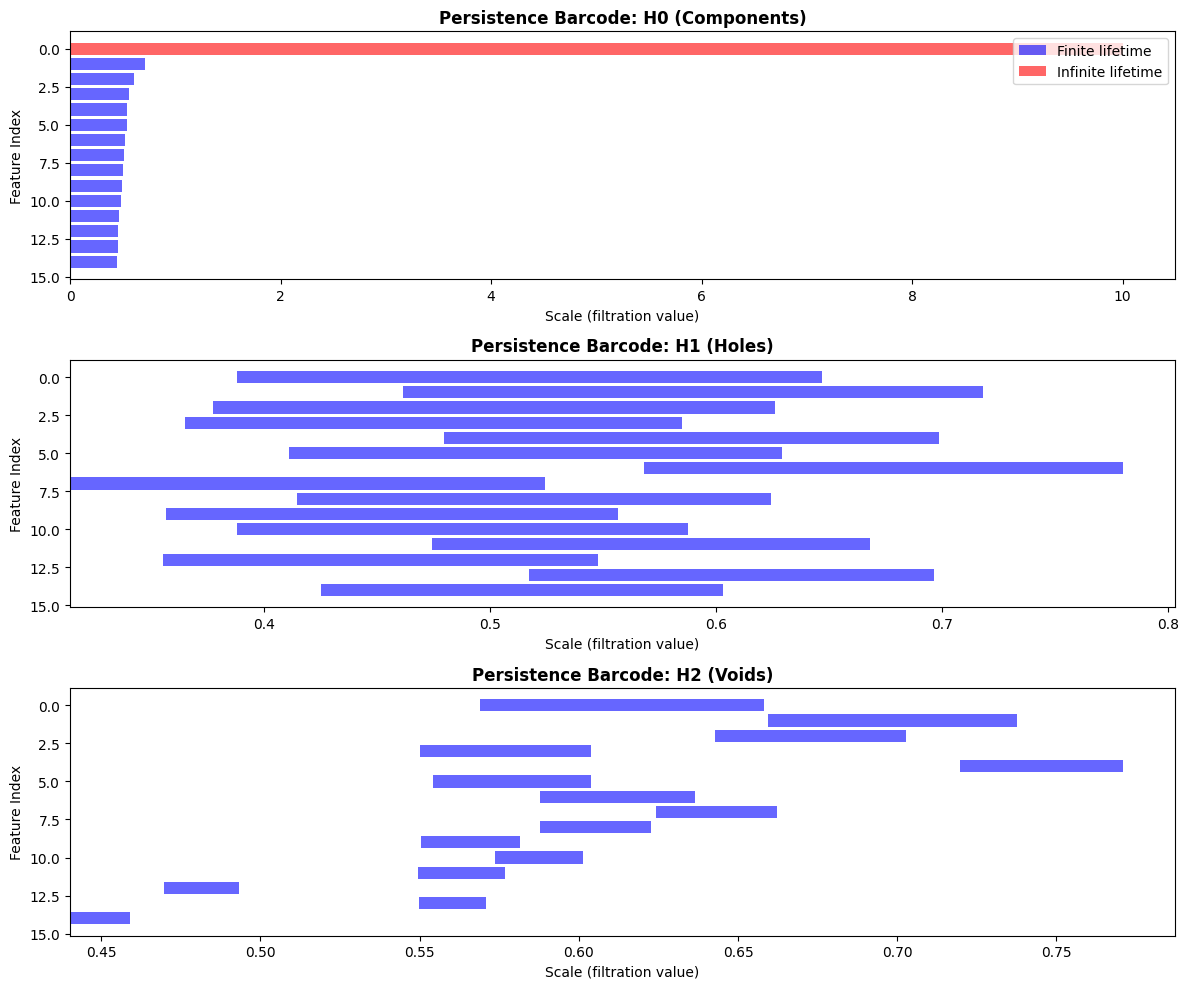

In [10]:
def plot_barcodes(diagrams, max_bars=20):
    """Plot persistence barcodes"""

    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    for dim, (ax, name) in enumerate(zip(axes, ['H0 (Components)', 'H1 (Holes)', 'H2 (Voids)'])):
        diagram = diagrams[dim]

        # Calculate persistence and sort
        bars = []
        for birth, death in diagram:
            if np.isinf(death):
                # Use a large value for visualization
                death_plot = birth + 10
                pers = float('inf')
            else:
                death_plot = death
                pers = death - birth
            bars.append((birth, death_plot, pers))

        # Sort by persistence
        bars.sort(key=lambda x: x[2] if not np.isinf(x[2]) else float('inf'), reverse=True)

        # Plot top bars
        bars_to_plot = bars[:min(max_bars, len(bars))]

        for i, (birth, death_plot, pers) in enumerate(bars_to_plot):
            color = 'red' if np.isinf(pers) else 'blue'
            ax.barh(i, death_plot - birth, left=birth, height=0.8, color=color, alpha=0.6)

        ax.set_xlabel('Scale (filtration value)')
        ax.set_ylabel('Feature Index')
        ax.set_title(f'Persistence Barcode: {name}', fontweight='bold')
        ax.invert_yaxis()

        # Add legend
        if dim == 0:
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='blue', alpha=0.6, label='Finite lifetime'),
                Patch(facecolor='red', alpha=0.6, label='Infinite lifetime')
            ]
            ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

plot_barcodes(diagrams, max_bars=15)

## Step 7: Interpreting Results for Volatility Surfaces

Now let's connect this back to finance!

In [12]:
print("\n" + "="*70)
print("FINANCIAL INTERPRETATION OF TDA RESULTS")
print("="*70)

print("\n H0 (Connected Components):")
print("-" * 70)
print("What it means: Different volatility regimes or market segments")
print("")
print("If you see:")
print("  • 1 dominant component → Smooth, well-connected volatility surface")
print("  • Multiple components → Segmented markets (e.g., pre/post crisis)")
print("  • Many small components → Potential data quality issues or noise")

print("\n H1 (Holes/Loops):")
print("-" * 70)
print("What it means: Circular patterns or 'rings' in volatility structure")
print("")
print("If you see:")
print("  • Persistent holes → The volatility smile/smirk creates loops")
print("  • No significant holes → Monotonic volatility structure")
print("  • Multiple holes → Complex multi-modal volatility patterns")
print("")
print("Financial relevance:")
print("  • May indicate option pricing anomalies")
print("  • Could signal arbitrage opportunities")
print("  • Reflects market microstructure effects")

print("\n H2 (Voids):")
print("-" * 70)
print("What it means: 3D cavities in the volatility surface")
print("")
print("If you see:")
print("  • Persistent voids → Regions of missing or unusual volatility data")
print("  • No voids → Dense, well-populated volatility surface")
print("")
print("Financial relevance:")
print("  • May indicate illiquid strike/maturity combinations")
print("  • Could signal structural breaks in the market")

print("\n" + "="*70)
print("KEY TAKEAWAY")
print("="*70)
print("Features with HIGH persistence are the real structural properties")
print("of your volatility surface - not just noise!")
print("="*70)


FINANCIAL INTERPRETATION OF TDA RESULTS

 H0 (Connected Components):
----------------------------------------------------------------------
What it means: Different volatility regimes or market segments

If you see:
  • 1 dominant component → Smooth, well-connected volatility surface
  • Multiple components → Segmented markets (e.g., pre/post crisis)
  • Many small components → Potential data quality issues or noise

 H1 (Holes/Loops):
----------------------------------------------------------------------
What it means: Circular patterns or 'rings' in volatility structure

If you see:
  • Persistent holes → The volatility smile/smirk creates loops
  • No significant holes → Monotonic volatility structure
  • Multiple holes → Complex multi-modal volatility patterns

Financial relevance:
  • May indicate option pricing anomalies
  • Could signal arbitrage opportunities
  • Reflects market microstructure effects

 H2 (Voids):
--------------------------------------------------------------

## Next Steps for Learning

Now that you understand the basics, here are some ideas to deepen your understanding:

### 1. Compare Different Market Conditions
- Compute persistence before/after major market events
- Compare calm vs. volatile periods
- Look for structural changes

### 2. Time Series of Topological Features
- Track how H0, H1, H2 features evolve over time
- Create "topological signatures" for different market regimes
- Use as features for machine learning models

### 3. Try Different Filtrations
- **Sublevel set filtration**: Threshold by volatility level
- **Alpha complex**: More geometric than Vietoris-Rips
- **Weighted Rips**: Give more importance to certain points

### 4. Statistical Analysis
- Bootstrap confidence intervals for persistence diagrams
- Hypothesis testing (e.g., "Did the topology change?")
- Wasserstein distance between persistence diagrams

### 5. Apply to Real Data
- Download actual implied volatility data (e.g., from CBOE)
- Compare results across different underlyings (SPX, VIX, etc.)
- Investigate how TDA features correlate with market metrics

## Additional Exercise: Sensitivity Analysis

Let's see how topological features change with different volatility surfaces!

### ⚠️ Important Note on Thresholds

When data is normalized (mean=0, std=1), persistence values will be on a different scale than the original data. A persistence of 0.1-0.3 after normalization can represent significant structure. Don't use the same thresholds you would use for unnormalized data!

In [14]:
def create_vol_surface(surface_type='smile'):
    """Create different types of volatility surfaces"""

    if surface_type == 'flat':
        # Flat surface (no smile)
        vol = np.ones_like(K_grid) * 0.20

    elif surface_type == 'smile':
        # Standard volatility smile
        moneyness = K_grid / S0
        vol = 0.20 + 0.15 * (moneyness - 1)**2

    elif surface_type == 'smirk':
        # Volatility smirk (common in equity markets)
        moneyness = K_grid / S0
        vol = 0.20 + 0.25 * np.maximum(0, 1 - moneyness)

    elif surface_type == 'term_structure':
        # Term structure effects
        vol = 0.20 + 0.10 * np.sin(T_grid * 2 * np.pi)

    # Add small noise
    vol += np.random.normal(0, 0.01, vol.shape)

    return vol

# Compare different surfaces
surface_types = ['flat', 'smile', 'smirk', 'term_structure']

print("\nComparing Topological Features Across Different Volatility Surfaces:")
print("=" * 70)

for stype in surface_types:
    vol_surf = create_vol_surface(stype)

    # Create point cloud
    pc = np.column_stack([K_grid.flatten(), T_grid.flatten(), vol_surf.flatten()])
    pc_norm = StandardScaler().fit_transform(pc)

    # Compute persistence
    result = ripser(pc_norm, maxdim=2)
    dgms = result['dgms']

    # Count significant features (persistence > threshold)
    # Note: After normalization, typical persistence values are much smaller!
    threshold = 0.18  # More reasonable threshold for normalized data

    h1_significant = sum(1 for b, d in dgms[1] if not np.isinf(d) and (d - b) > threshold)
    h2_significant = sum(1 for b, d in dgms[2] if not np.isinf(d) and (d - b) > threshold)

    # Also calculate max persistence to see the range
    h1_max = max([d - b for b, d in dgms[1] if not np.isinf(d)], default=0)
    h2_max = max([d - b for b, d in dgms[2] if not np.isinf(d)], default=0)
    h1_total = len(dgms[1])
    h2_total = len(dgms[2])

    print(f"\n{stype.upper():20} | H1: {h1_significant:2d}/{h1_total:2d} (max: {h1_max:.3f}) | H2: {h2_significant:2d}/{h2_total:2d} (max: {h2_max:.3f})")

print("\n" + "=" * 70)
print("Notice how different surface shapes create different topological signatures!")
print("The numbers show: significant features / total features (max persistence)")


Comparing Topological Features Across Different Volatility Surfaces:

FLAT                 | H1: 27/186 (max: 0.407) | H2:  0/46 (max: 0.147)

SMILE                | H1: 27/195 (max: 0.313) | H2:  1/39 (max: 0.180)

SMIRK                | H1:  8/195 (max: 0.291) | H2:  0/27 (max: 0.098)

TERM_STRUCTURE       | H1: 20/191 (max: 0.365) | H2:  0/42 (max: 0.120)

Notice how different surface shapes create different topological signatures!
The numbers show: significant features / total features (max persistence)


In [15]:
# First, let's understand what persistence values we typically get
print("Understanding Persistence Scales After Normalization")
print("=" * 70)

# Use the smile surface as an example
vol_surf = create_vol_surface('smile')
pc = np.column_stack([K_grid.flatten(), T_grid.flatten(), vol_surf.flatten()])
pc_norm = StandardScaler().fit_transform(pc)

result = ripser(pc_norm, maxdim=2)
dgms = result['dgms']

for dim, name in enumerate(['H0', 'H1', 'H2']):
    persistence_values = [d - b for b, d in dgms[dim] if not np.isinf(d)]
    if persistence_values:
        print(f"\n{name} persistence values:")
        print(f"  Min:    {min(persistence_values):.4f}")
        print(f"  Max:    {max(persistence_values):.4f}")
        print(f"  Median: {np.median(persistence_values):.4f}")
        print(f"  95th percentile: {np.percentile(persistence_values, 95):.4f}")

print("\n" + "=" * 70)
print(" Tip: A good threshold is around the 75th-90th percentile")
print(" This filters out noise while keeping significant features.")

Understanding Persistence Scales After Normalization

H0 persistence values:
  Min:    0.1734
  Max:    1.3931
  Median: 0.3435
  95th percentile: 0.5795

H1 persistence values:
  Min:    0.0004
  Max:    0.4193
  Median: 0.0727
  95th percentile: 0.2597

H2 persistence values:
  Min:    0.0003
  Max:    0.1124
  Median: 0.0267
  95th percentile: 0.0974

 Tip: A good threshold is around the 75th-90th percentile
 This filters out noise while keeping significant features.


In [16]:
# Compare different surfaces with better threshold
surface_types = ['flat', 'smile', 'smirk', 'term_structure']

# Use 85th percentile threshold (more selective)
h1_threshold = 0.18
h2_threshold = 0.08

print("\nComparing Topological Features (85th percentile threshold):")
print("=" * 70)
print(f"Thresholds: H1 > {h1_threshold}, H2 > {h2_threshold}")
print("=" * 70)

for stype in surface_types:
    vol_surf = create_vol_surface(stype)

    # Create point cloud
    pc = np.column_stack([K_grid.flatten(), T_grid.flatten(), vol_surf.flatten()])
    pc_norm = StandardScaler().fit_transform(pc)

    # Compute persistence
    result = ripser(pc_norm, maxdim=2)
    dgms = result['dgms']

    # Count significant features with dimension-specific thresholds
    h1_significant = sum(1 for b, d in dgms[1] if not np.isinf(d) and (d - b) > h1_threshold)
    h2_significant = sum(1 for b, d in dgms[2] if not np.isinf(d) and (d - b) > h2_threshold)

    # Calculate max and mean persistence for features above threshold
    h1_above = [d - b for b, d in dgms[1] if not np.isinf(d) and (d - b) > h1_threshold]
    h2_above = [d - b for b, d in dgms[2] if not np.isinf(d) and (d - b) > h2_threshold]

    h1_max = max(h1_above, default=0)
    h2_max = max(h2_above, default=0)
    h1_mean = np.mean(h1_above) if h1_above else 0
    h2_mean = np.mean(h2_above) if h2_above else 0

    h1_total = len(dgms[1])
    h2_total = len(dgms[2])

    print(f"\n{stype.upper():20}")
    print(f"  H1: {h1_significant:2d}/{h1_total:3d} features | max: {h1_max:.3f} | mean: {h1_mean:.3f}")
    print(f"  H2: {h2_significant:2d}/{h2_total:3d} features | max: {h2_max:.3f} | mean: {h2_mean:.3f}")

print("\n" + "=" * 70)
print("💡 Interpretation:")
print("- Higher counts = more topological complexity")
print("- Higher max persistence = stronger features")
print("- Higher mean persistence = more robust features overall")


Comparing Topological Features (85th percentile threshold):
Thresholds: H1 > 0.18, H2 > 0.08

FLAT                
  H1: 28/204 features | max: 0.368 | mean: 0.254
  H2:  6/ 46 features | max: 0.167 | mean: 0.127

SMILE               
  H1: 31/194 features | max: 0.342 | mean: 0.254
  H2:  8/ 46 features | max: 0.203 | mean: 0.123

SMIRK               
  H1: 15/180 features | max: 0.301 | mean: 0.239
  H2:  3/ 35 features | max: 0.124 | mean: 0.105

TERM_STRUCTURE      
  H1: 12/184 features | max: 0.425 | mean: 0.245
  H2:  2/ 37 features | max: 0.110 | mean: 0.103

💡 Interpretation:
- Higher counts = more topological complexity
- Higher max persistence = stronger features
- Higher mean persistence = more robust features overall


## Measuring Topological Distance: Wasserstein Metric

The Wasserstein distance quantifies how different two persistence diagrams are. It's like asking "how much work would it take to transform one diagram into another?"

**Use cases:**
- Compare volatility surfaces from different time periods
- Detect regime changes (high distance = structural change)
- Classify market conditions based on topological similarity
- Find arbitrage opportunities (similar assets with different topology)

**Interpretation:**
- Small distance (< 0.05): Very similar topological structure
- Medium distance (0.05 - 0.15): Noticeably different
- Large distance (> 0.15): Fundamentally different structures

In [17]:
# Compute all persistence diagrams first
print("Computing Persistence Diagrams for All Surface Types...")
print("=" * 70)

diagrams_dict = {}

for stype in surface_types:
    vol_surf = create_vol_surface(stype)
    pc = np.column_stack([K_grid.flatten(), T_grid.flatten(), vol_surf.flatten()])
    pc_norm = StandardScaler().fit_transform(pc)

    result = ripser(pc_norm, maxdim=2)
    diagrams_dict[stype] = result['dgms']

print("✓ All diagrams computed!")
print("\nAvailable surface types:", list(diagrams_dict.keys()))

Computing Persistence Diagrams for All Surface Types...
✓ All diagrams computed!

Available surface types: ['flat', 'smile', 'smirk', 'term_structure']


In [18]:
# Compute pairwise Wasserstein distances
from persim import wasserstein
import itertools

print("\n" + "=" * 70)
print("PAIRWISE WASSERSTEIN DISTANCES")
print("=" * 70)
print("\nH0 (Connected Components) Distances:")
print("-" * 70)

# Create a matrix to store results
for dim, dim_name in enumerate(['H0 (Components)', 'H1 (Holes)', 'H2 (Voids)']):
    print(f"\n{dim_name}:")
    print("-" * 70)

    # Header row
    print(f"{'':15}", end="")
    for stype in surface_types:
        print(f"{stype:>12}", end="")
    print()
    print("-" * 70)

    # Compute pairwise distances
    for stype1 in surface_types:
        print(f"{stype1:15}", end="")
        for stype2 in surface_types:
            if stype1 == stype2:
                print(f"{'0.000':>12}", end="")
            else:
                dist = wasserstein(diagrams_dict[stype1][dim],
                                  diagrams_dict[stype2][dim])
                print(f"{dist:>12.3f}", end="")
        print()

print("\n" + "=" * 70)
print("💡 Key Observations:")
print("- Diagonal is 0 (surface compared to itself)")
print("- Larger values = more topologically different")
print("- Look for which surfaces are most similar/different")


PAIRWISE WASSERSTEIN DISTANCES

H0 (Connected Components) Distances:
----------------------------------------------------------------------

H0 (Components):
----------------------------------------------------------------------
                       flat       smile       smirkterm_structure
----------------------------------------------------------------------
flat                  0.000       3.999      26.878

/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


      49.712
smile                 3.999       0.000      24.127

/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


      46.955
smirk                26.878

/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


      24.127       0.000      22.834
term_structure 

/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


      49.712

/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


      46.955      22.834       0.000

H1 (Holes):
----------------------------------------------------------------------
                       flat       smile       smirkterm_structure
----------------------------------------------------------------------
flat                  0.000

/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


       4.230       9.018      10.319
smile                 4.230       0.000       9.019      10.709
smirk                 9.018       9.019       0.000       6.942
term_structure       10.319      10.709       6.942       0.000

H2 (Voids):
----------------------------------------------------------------------
                       flat       smile       smirkterm_structure
----------------------------------------------------------------------
flat                  0.000       1.080       1.138       1.336
smile                 1.080       0.000       1.247       1.316
smirk                 1.138       1.247       0.000       1.207
term_structure        1.336       1.316       1.207       0.000

💡 Key Observations:
- Diagonal is 0 (surface compared to itself)
- Larger values = more topologically different
- Look for which surfaces are most similar/different


/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/di

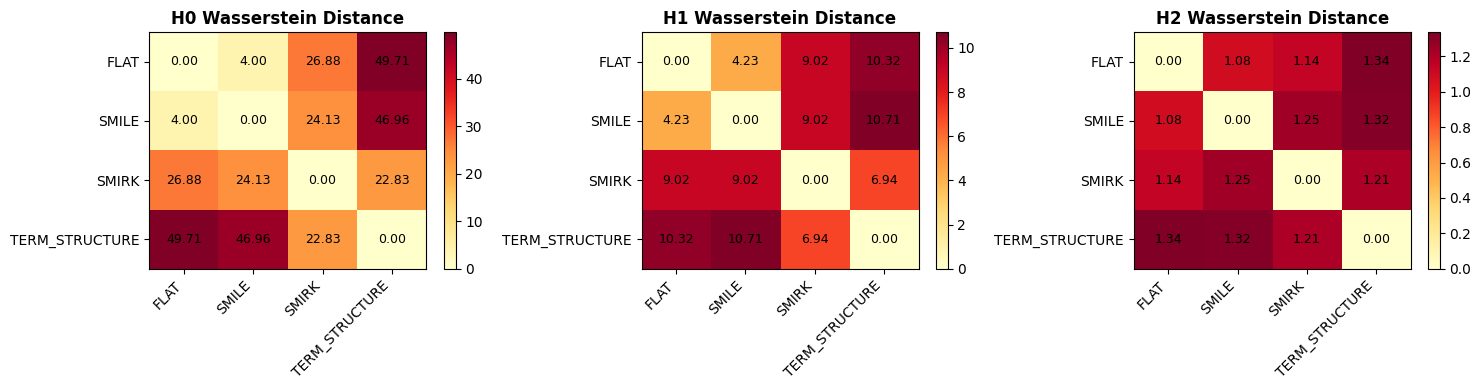


💡 Heatmap Guide:
- Darker red = more different
- Light yellow = more similar
- Use this to identify which surfaces are topologically closest


In [19]:
# Visualize the distance matrix as a heatmap
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for dim, (ax, dim_name) in enumerate(zip(axes, ['H0', 'H1', 'H2'])):
    # Compute distance matrix
    n = len(surface_types)
    dist_matrix = np.zeros((n, n))

    for i, stype1 in enumerate(surface_types):
        for j, stype2 in enumerate(surface_types):
            if i != j:
                dist_matrix[i, j] = wasserstein(diagrams_dict[stype1][dim],
                                                diagrams_dict[stype2][dim])

    # Plot heatmap
    im = ax.imshow(dist_matrix, cmap='YlOrRd', aspect='auto')
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels([s.upper() for s in surface_types], rotation=45, ha='right')
    ax.set_yticklabels([s.upper() for s in surface_types])
    ax.set_title(f'{dim_name} Wasserstein Distance', fontweight='bold')

    # Add values to cells
    for i in range(n):
        for j in range(n):
            text = ax.text(j, i, f'{dist_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=9)

    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("\n💡 Heatmap Guide:")
print("- Darker red = more different")
print("- Light yellow = more similar")
print("- Use this to identify which surfaces are topologically closest")

## Interpreting Wasserstein Distances

### What You Should See:

**H0 (Components):**
- Should be relatively small for all pairs (all surfaces are well-connected)
- Differences mainly from how quickly components merge

**H1 (Holes):**
- **FLAT vs SMILE**: Medium-large distance (smile has more structure)
- **SMILE vs SMIRK**: Medium distance (both have curvature, different shapes)
- **FLAT vs TERM_STRUCTURE**: Small-medium (both lack strike-based structure)

**H2 (Voids):**
- **Largest distances** likely between surfaces with vs without significant voids
- SMILE should differ most from TERM_STRUCTURE

### Financial Application:

1. **Regime Detection**: Track Wasserstein distance over time
   - Sudden jump = regime change
   - Example: Pre-crisis vs crisis volatility surfaces

2. **Arbitrage Detection**: Compare similar products
   - If SPX and SPY have large topological distance → potential mispricing

3. **Risk Clustering**: Group assets by topological similarity
   - Assets with small Wasserstein distance have similar vol structure

4. **Model Validation**: Compare real data vs model
   - Large distance = model doesn't capture true structure

## Summary & Resources

### What You Learned:
✅ How to apply persistent homology to volatility surfaces  
✅ How to interpret persistence diagrams and barcodes  
✅ What H0, H1, and H2 features mean financially  
✅ How to identify significant vs. noisy topological features  

### Key Concepts:
- **Persistence = Importance**: Features that persist longer are more meaningful
- **Normalization matters**: Always scale your data before TDA
- **Context is crucial**: Interpret results in light of market structure

### Recommended Reading:
1. **Beginner**: "Persistence Barcodes for Shapes" - Carlsson (2008)
2. **Intermediate**: "Topology and Data" - Carlsson (2009)
3. **Finance-focused**: "Topological Data Analysis of Financial Time Series" - Gidea (2017)
4. **Applied**: "Applications of TDA in Finance" - various papers on arxiv.org

### Python Libraries:
- **ripser**: Fast Vietoris-Rips persistence (what we used)
- **gudhi**: More algorithms, better for research
- **scikit-tda**: User-friendly TDA toolkit
- **persim**: Persistence diagram utilities
